<center><h2>DSCI 100 Group Project Proposal</h2></center>
<div style="text-align: right"> DSCI 100 008 </div>
<div style="text-align: right"> Group 21 </div>
<div style="text-align: right"> Ellie Wakefield </div>
<div style="text-align: right"> Ryan Lee </div>
<div style="text-align: right"> Samantha Tang </div>
<div style="text-align: right"> Soumil Ahuja </div>

<h3>Introduction</h3>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The Heart Disease “Cleveland data set” obtained from the UCI Machine Learning Repository will be used to predict the presence of heart disease. This dataset measures 66 different variables pertaining to heart disease for 303 participants. In order to determine the presence of heart disease, the dataset uses angiographic status. An angiography is recommended for patients that suffer from angina (chest pain) and is used to determine whether or not someone has heart disease. While the dataset classifies the angiography results into 4 levels of severity, we will simplify this and only look at whether heart disease is present (1) or absent (0).

<h3>Preliminary Exploratory Data Analysis</h3>

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#loading data frame, assigning column names, changing angina column to factor type, & selecting the columns we need
heart_data <- read_csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"), col_names = FALSE) |>
    rename(age=X1, sex=X2,chest_pain_type=X3, resting_blood_pressure=X4, serum_cholesteral=X5, fasting_blood_sugar=X6,
           resting_electrocardiographic_results=X7, max_heart_rate=X8, exercise_induced_angina=X9, ST_depression=X10,
           slope=X11, number_vessels=X12, thal=X13, angiographic_status=X14) |>
    #mutate(exercise_induced_angina=as.factor(exercise_induced_angina)) |> 
    #mutate(sex=as.factor(sex)) |>
    #mutate(resting_electrocardiographic_results=as.factor(resting_electrocardiographic_results)) |>
    #mutate(angiographic_status=as.factor(angiographic_status)) |>
    select(age, sex, resting_blood_pressure, serum_cholesteral, resting_electrocardiographic_results, exercise_induced_angina, angiographic_status)

#Create a new row to simplify
#angiographic_status of 0 means no presence of heart disease
#angiographic_status of more than 0 means heart disease
heart_data["heart_disease_presence"] <- 0
for(i in 1:nrow(heart_data)) {
    if(heart_data[i, ncol(heart_data)-1] == 0) {
        heart_data[i, ncol(heart_data)] <- 0
    } else {
        heart_data[i, ncol(heart_data)] <- 1
    }    
}
#no longer need angiograpic_status
heart_data <- heart_data |>
    select(-angiographic_status) |>
    mutate(heart_disease_presence = as.factor(heart_disease_presence))
heart_data 

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,resting_blood_pressure,serum_cholesteral,resting_electrocardiographic_results,exercise_induced_angina,heart_disease_presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,145,233,2,0,0
67,1,160,286,2,1,1
67,1,120,229,2,1,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,130,131,0,1,1
57,0,130,236,2,0,1
38,1,138,175,0,0,0


In [3]:
#Split up data into training and testing
set.seed(21)
heart_split <- initial_split(heart_data, prop = 0.75, strata = heart_disease_presence)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [4]:
#converts numerical sex value into a letter eg 0 -> F. Creates a new column for it
#done purely for the charts - F/M easier to read than 0/1
temp_heart_train <- heart_train
temp_heart_train["sex_letter"] <- NA
for(i in 1:nrow(temp_heart_train)) {
    if(temp_heart_train[i, 2] == 0) {
        temp_heart_train[i, ncol(temp_heart_train)] <- "F"
    } else {
        temp_heart_train[i, ncol(temp_heart_train)] <- "M"
    }    
}

#Table of mean age and cholesteral for each heart disease presence/sex combination
mean_age_angiographic <- temp_heart_train |>
    group_by(heart_disease_presence, sex_letter) |>
    summarize(mean_age=round(mean(age),1), mean_cholesteral = round(mean(serum_cholesteral)), n=n())
#is there a better way to label the table?
print("Summary table of heart disease presence by sex")
mean_age_angiographic

`summarise()` has grouped output by 'heart_disease_presence'. You can override
using the `.groups` argument.


[1] "Summary table of heart disease presence by sex"


heart_disease_presence,sex_letter,mean_age,mean_cholesteral,n
<fct>,<chr>,<dbl>,<dbl>,<int>
0,F,54.3,255,52
0,M,50.9,235,71
1,F,59.4,273,18
1,M,55.7,247,86


In this summary table, we find that there are 55 women without heart disease, 68 men without heart disease, 18 women with heart disease, and 86 men with heart disease. It is hard to interpret these numbers without finding proportions or visualizing the numbers, so next we will create a visualization to help us do this. 

`summarise()` has grouped output by 'sex_letter'. You can override using the
`.groups` argument.


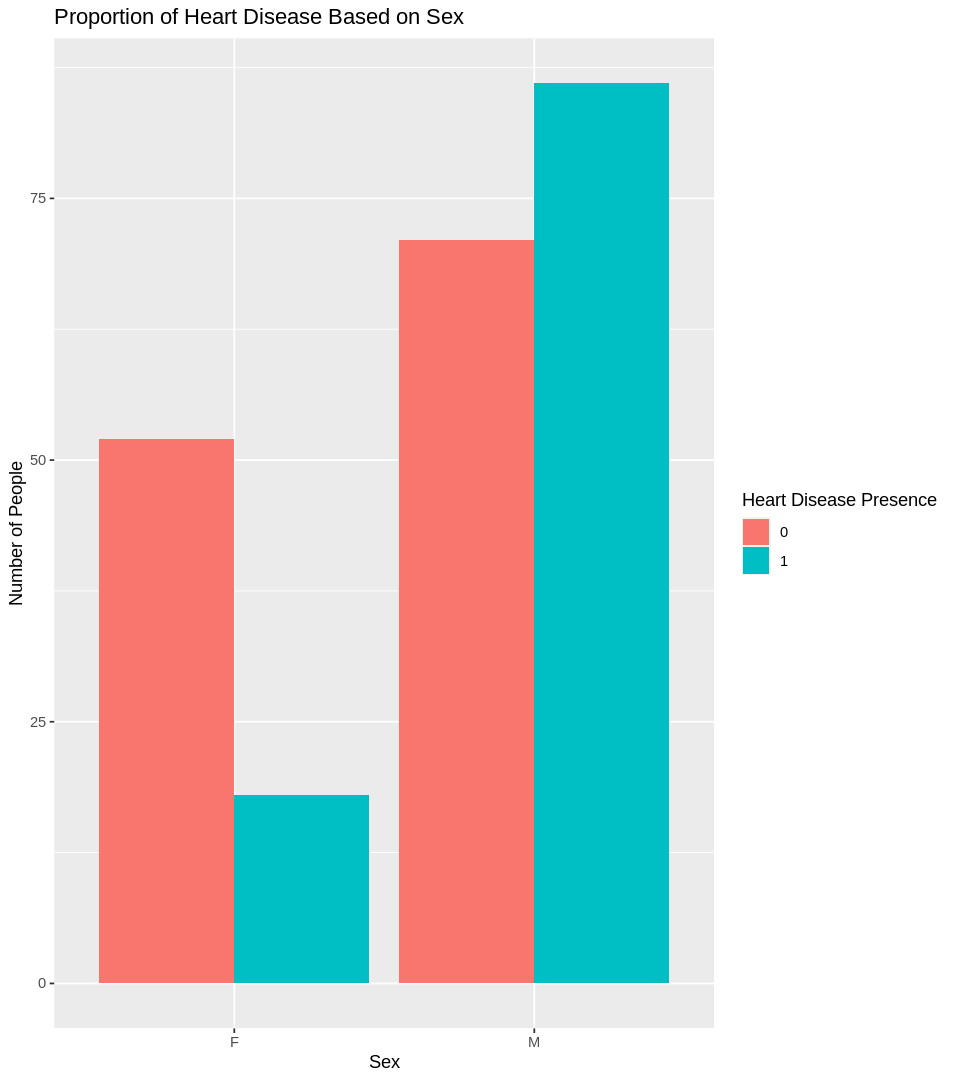

In [5]:
#Uses modified dataset purely for graphs/charts
#counts number of people in each sex/heart disease presence combination
temp_heart_train <- temp_heart_train |>
    group_by(sex_letter, heart_disease_presence) |>
    summarize(n=n())

temp_heart_train <- temp_heart_train |>
    mutate(heart_disease_presence = as.factor(heart_disease_presence))


options(repr.plot.width = 8, repr.plot.height = 9)
heart_plot <- temp_heart_train |> 
    ggplot(aes(x = sex_letter, y = n, fill = heart_disease_presence)) +
    geom_bar(stat = "identity", position = "dodge") +
    xlab("Sex") +
    ylab("Number of People") +
    labs(fill = "Heart Disease Presence")+
    ggtitle("Proportion of Heart Disease Based on Sex")
heart_plot
#they told us to label our tables and graphs but we did label the graph? 
#does anyone know what she meant by that, or was she just referring to the table?

We chose to use a bar plot to depict the presence of heart disease among males and females because it helps us to visually compare the difference in heart disease presence by sex. We can see in the visualization that men appear to have higher rates of heart disease based on this data. 

<h3>Methods</h3>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
In order to train our K-nearest neighbor classifier, we will use age, maximum heart rate, chest pain type, cholesterol, resting blood pressure, and gender as predictors. All these variables were chosen due to their correlation with heart disease. The Cleveland Data Set will be used, and will be split up into a training and a testing group with a 75/25 split. In order to pick the correct number for K, we will show a graph plotting the number of neighbors versus accuracy estimates. We will then show a confusion matrix using the K result with the highest accuracy, allowing us to better visualize which types of errors were made by the classifier.

<h3>Expected Outcomes and Significance</h3>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
We expect that after using each of the predators, we can create a model that can classify the presence or absence of heart disease. Each of the predictors we use should have a correlation to the presence of heart disease, but certain predictors such as cholesterol and angina will have a stronger relationship with heart disease. 

<br />&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
If the classifier has a sufficiently high accuracy rate, it may be immensely helpful in predicting whether patients have heart disease. Patients can also determine symptoms that relate to heart disease and be more aware of the risks due their personal status. The results from this classifier and dataset can potentially act as a preventative measure to knowing which factors are highly correlated to heart disease. In addition, it could encourage some to pay closer attention to their health and lifestyle habits. For others with declining health, this classifier could classify heart disease while it is still in early stages. Future projects could focus on which variables better predict heart disease. While our predictors are the ones chosen for this classification analysis, other correlated variables could be used as well. Other projects could also focus on classifying all 4 levels of heart disease progression. 

<h1>going to do all the classifier stuff over here for now so i don't get it confused with the proposal</h1>

In [6]:
library(GGally)
heart_data <- read_csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"), col_names = FALSE) |>
    rename(age=X1, sex=X2,chest_pain_type=X3, resting_blood_pressure=X4, serum_cholesteral=X5, fasting_blood_sugar=X6,
           resting_electrocardiographic_results=X7, max_heart_rate=X8, exercise_induced_angina=X9, ST_depression=X10,
           slope=X11, number_vessels=X12, thal=X13, angiographic_status=X14) |>
    mutate(number_vessels=as.double(number_vessels)) |>
    mutate(thal=as.double(thal))
heart_data["heart_disease_presence"] <- 0
for(i in 1:nrow(heart_data)) {
    if(heart_data[i, ncol(heart_data)-1] == 0) {
        heart_data[i, ncol(heart_data)] <- 0
    } else {
        heart_data[i, ncol(heart_data)] <- 1
    }    
}

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


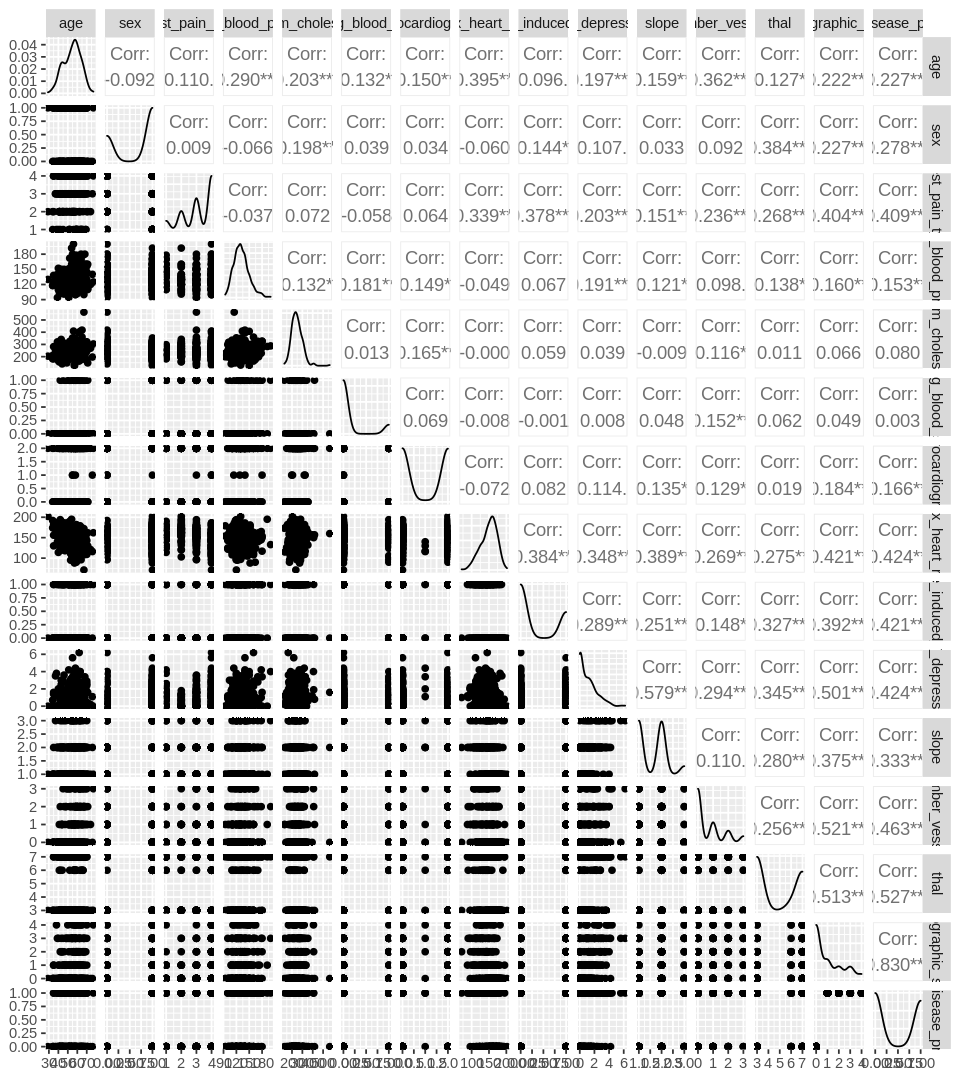

In [7]:
ggpairs(heart_data |> 
    na.omit())

chest_pain_type,max_heart_rate,exercise_induced_angina,ST_depression,number_vessels,thal,heart_disease_presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,2.3,0,6,0
4,108,1,1.5,3,3,1
4,129,1,2.6,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
4,141,0,3.4,2,7,1
4,115,1,1.2,1,7,1
2,174,0,0.0,1,3,1


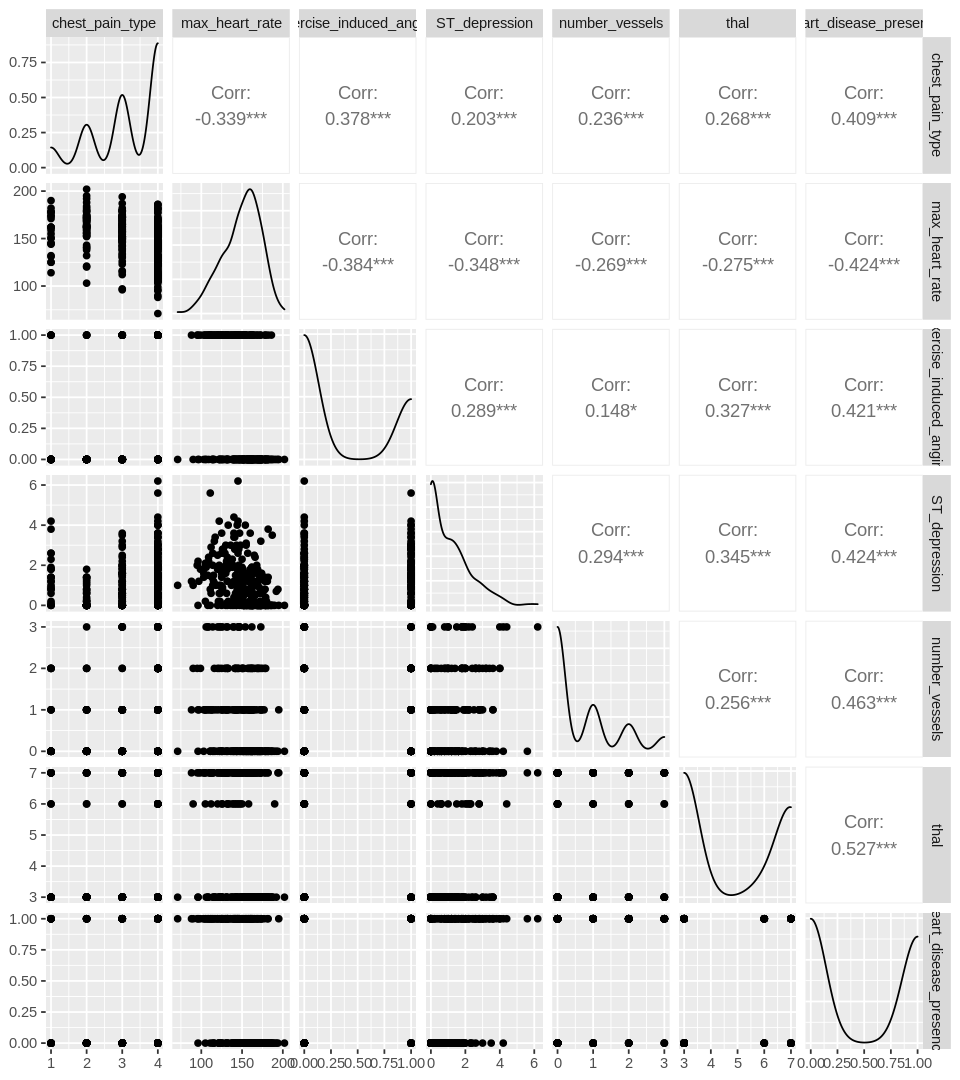

In [8]:
heart_data <- heart_data |>
    select(chest_pain_type,max_heart_rate,exercise_induced_angina,ST_depression,number_vessels,thal,heart_disease_presence) |>
    na.omit()
ggpairs(heart_data)
heart_data <- heart_data |>
    mutate(heart_disease_presence=as.factor(heart_disease_presence))
heart_data

heart_disease_presence,mean
<fct>,<dbl>
0,158.5813
1,139.1095


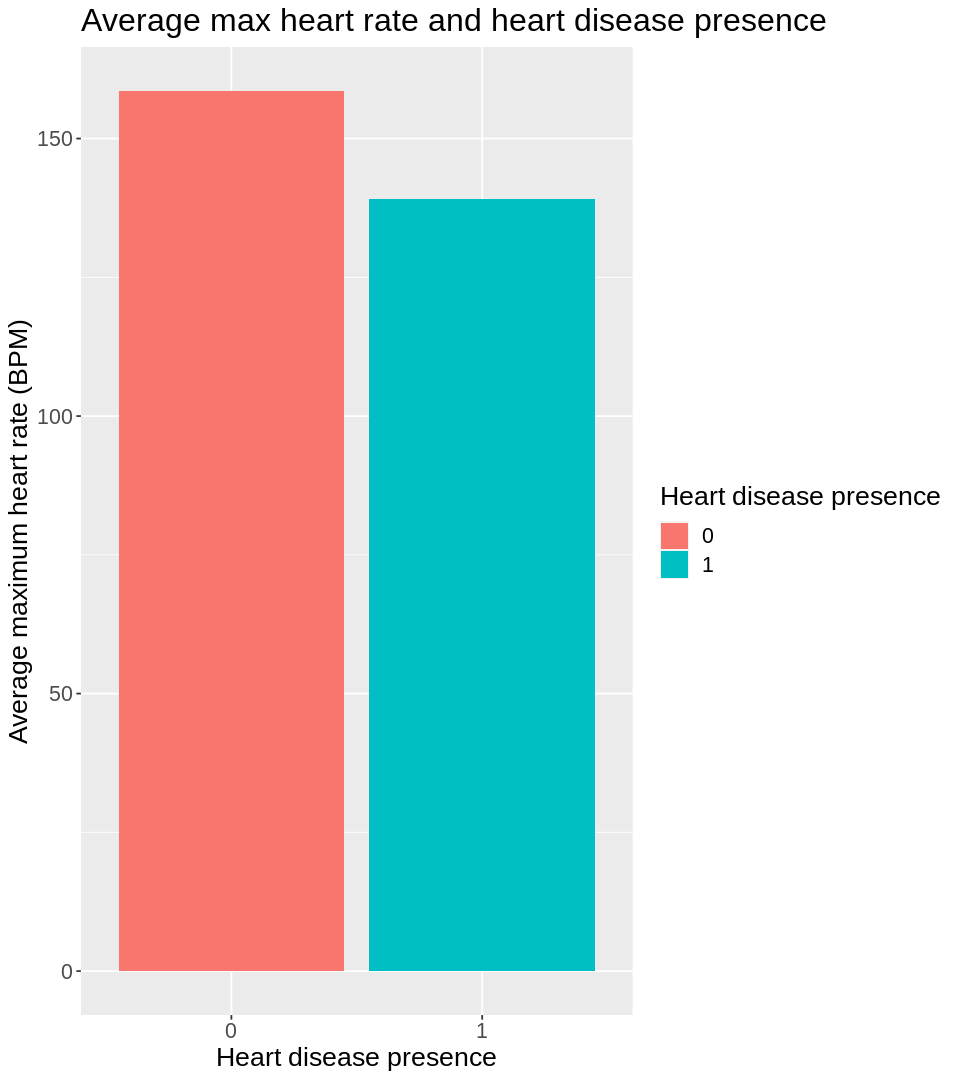

In [39]:
heart_data_summarized <- heart_data |> 
    select(max_heart_rate, heart_disease_presence) |> 
    group_by(heart_disease_presence) |>
    summarize(mean = mean(max_heart_rate))
heart_data_summarized
heart_rate_graph <- ggplot(heart_data_summarized, aes(y = mean, x = heart_disease_presence, fill = heart_disease_presence)) + 
    geom_bar(stat = "identity") + 
    labs(x = "Heart disease presence", y = "Average maximum heart rate (BPM)", fill = "Heart disease presence") + 
    theme(text = element_text(size = 16)) + 
    ggtitle("Average max heart rate and heart disease presence") 
heart_rate_graph

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,accuracy,binary,0.8243083,10,0.02389852,Preprocessor1_Model15


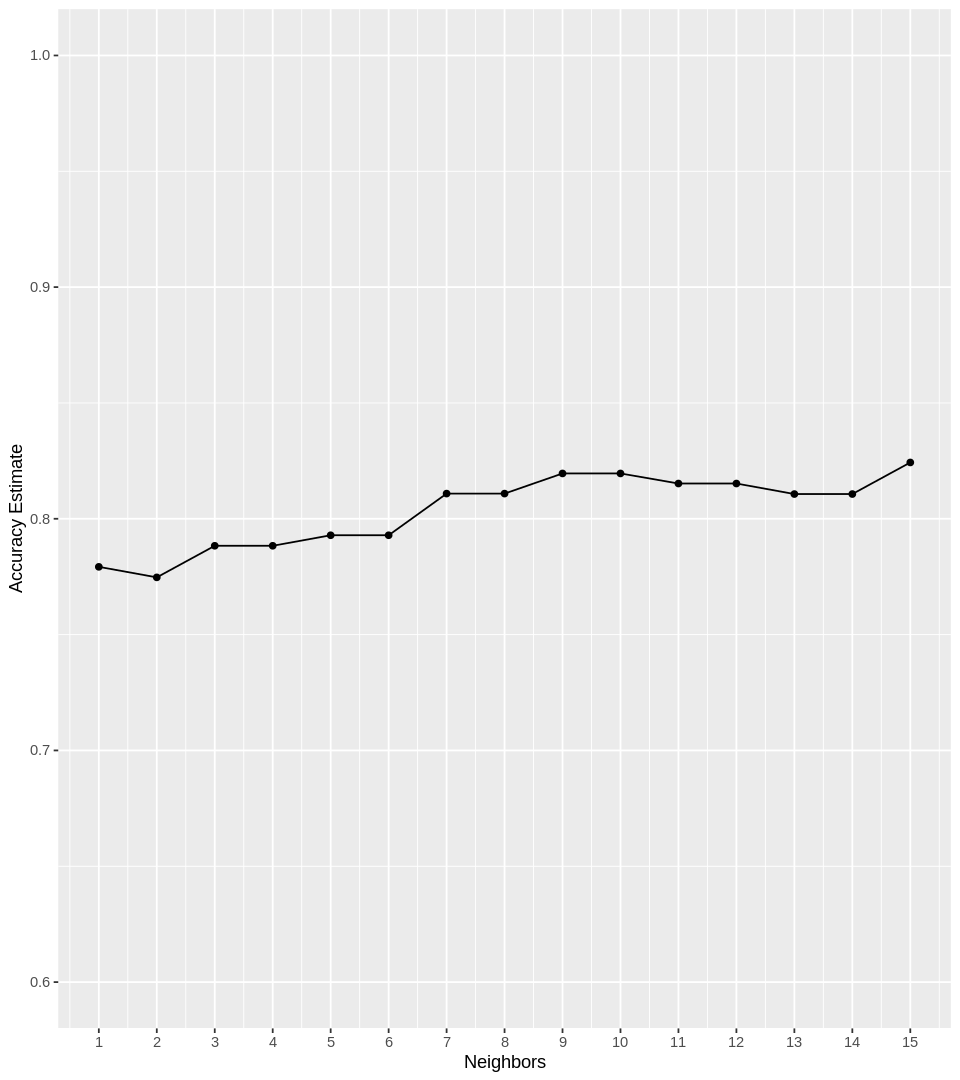

In [10]:
set.seed(1)
heart_split <- initial_split(heart_data, prop = 0.75, strata = heart_disease_presence)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_recipe <- recipe(heart_disease_presence ~., data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_vfold <- vfold_cv(heart_train, v = 10, strata = heart_disease_presence)

heart_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    tune_grid(resamples = heart_vfold, grid = 25) |>
    collect_metrics()
#heart_results
accuracies <- heart_results |>
    filter(.metric == "accuracy")
#max(accuracies$mean)
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 20, by = 1)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.6, 1.0)) # adjusting the y-axis
accuracies <- accuracies |>
    filter(.metric == "accuracy") |>
    arrange(mean)
tail(accuracies, 1)
accuracy_versus_k

In [57]:
heart_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit <- workflow() |> 
    add_recipe(heart_recipe) |> 
    add_model(heart_spec2) |> 
    fit(data = heart_train)

heart_test_predictions <- predict(heart_fit, heart_test) |>
    bind_cols(heart_test)

heart_predictions_accuracy <- heart_test_predictions |>
    metrics(truth = heart_disease_presence, estimate = .pred_class)
heart_predictions_accuracy

heart_mat <- heart_test_predictions |>
    conf_mat(truth = heart_disease_presence, estimate = .pred_class)
heart_mat

#i don't know what the point of this code is but i had it in my quiz notes for some reason
temp_heart_vfold <- vfold_cv(heart_train, v = 5, strata = heart_disease_presence)
temp_heart_resample_fit <- workflow() |> 
    add_recipe(heart_recipe) |> 
    add_model(heart_spec2) |> 
    fit_resamples(resamples = temp_heart_vfold)
temp_heart_metrics <- temp_heart_resample_fit |>
    collect_metrics()
temp_heart_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8000000
kap,binary,0.5989305


          Truth
Prediction  0  1
         0 32  7
         1  8 28

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.8152525,5,0.01830932,Preprocessor1_Model1
roc_auc,binary,0.8777976,5,0.01723272,Preprocessor1_Model1
